In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# load data
sp500_data = pd.read_excel("/Users/xieweixun/Desktop/S&P 500.xlsx")
csi300_data = pd.read_excel("/Users/xieweixun/Desktop/CSI300.xlsx")
# Clean the data by dropping any NaN values
sp500_data_cleaned = sp500_data.dropna()
csi300_data_cleaned = csi300_data.dropna()
# Calculate the daily returns
sp500_data_cleaned['Daily_Return'] = sp500_data_cleaned[' Close'].pct_change() 
csi300_data_cleaned['Daily_Return'] = csi300_data_cleaned[' Close'].pct_change() 

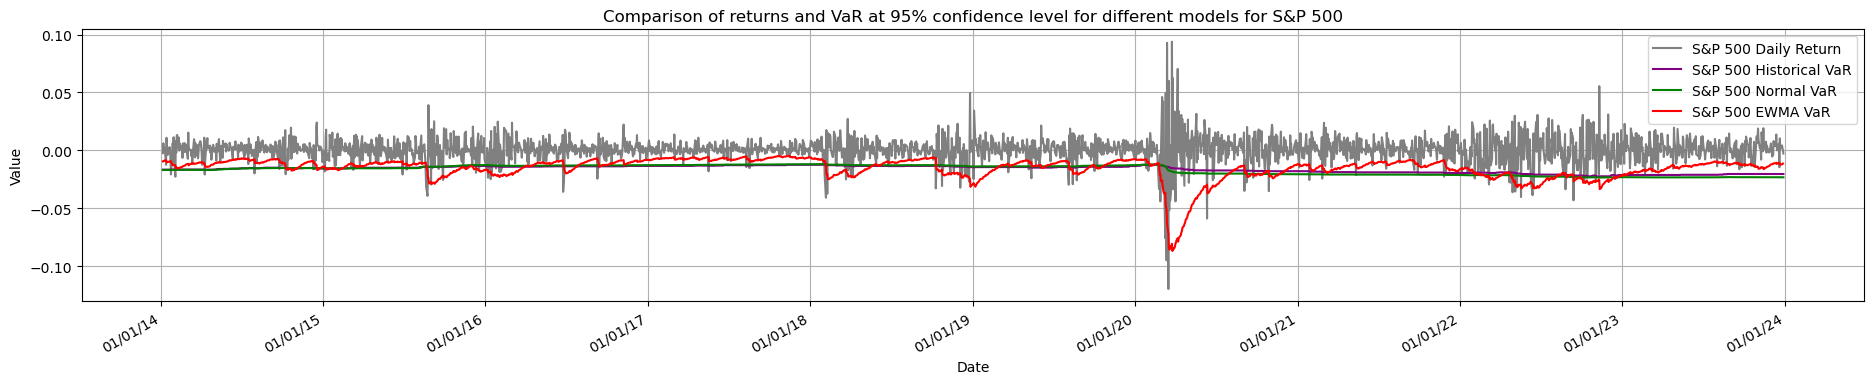

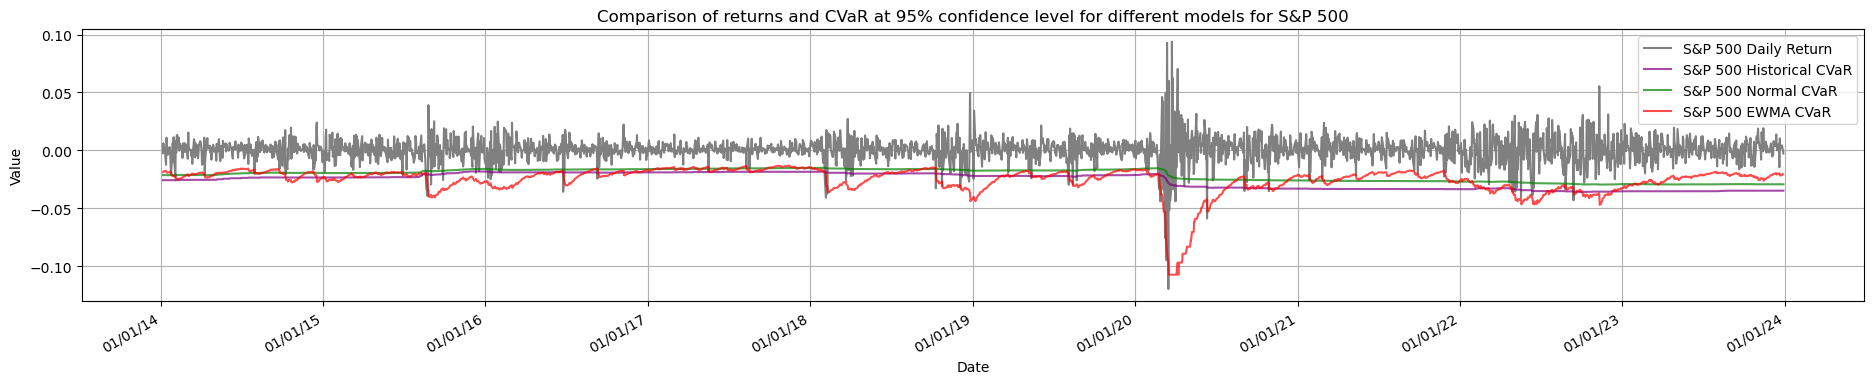

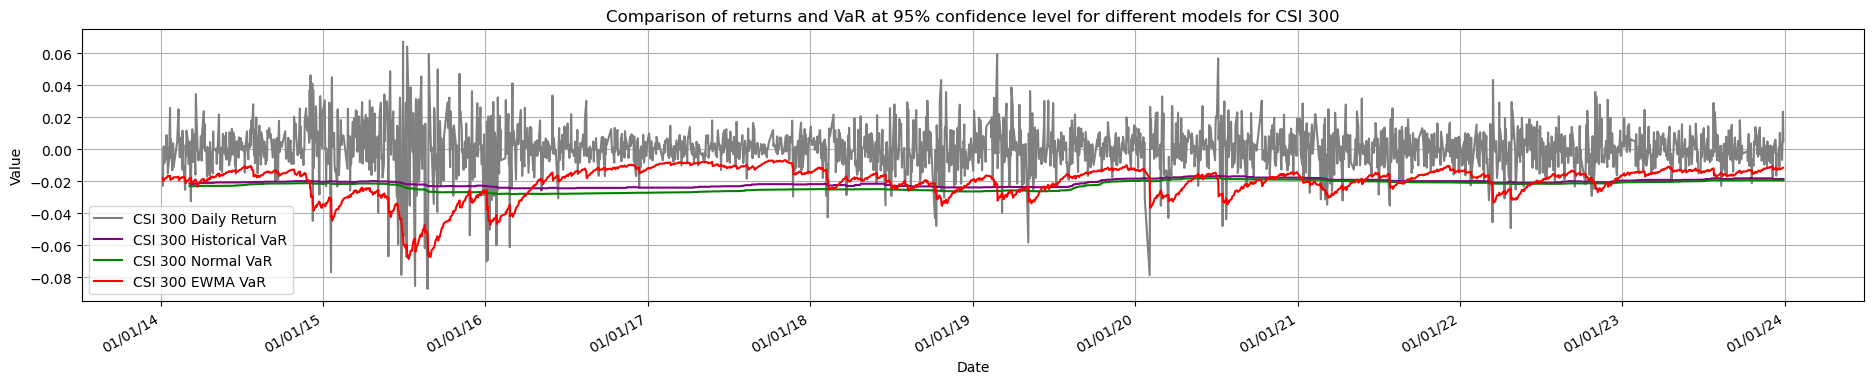

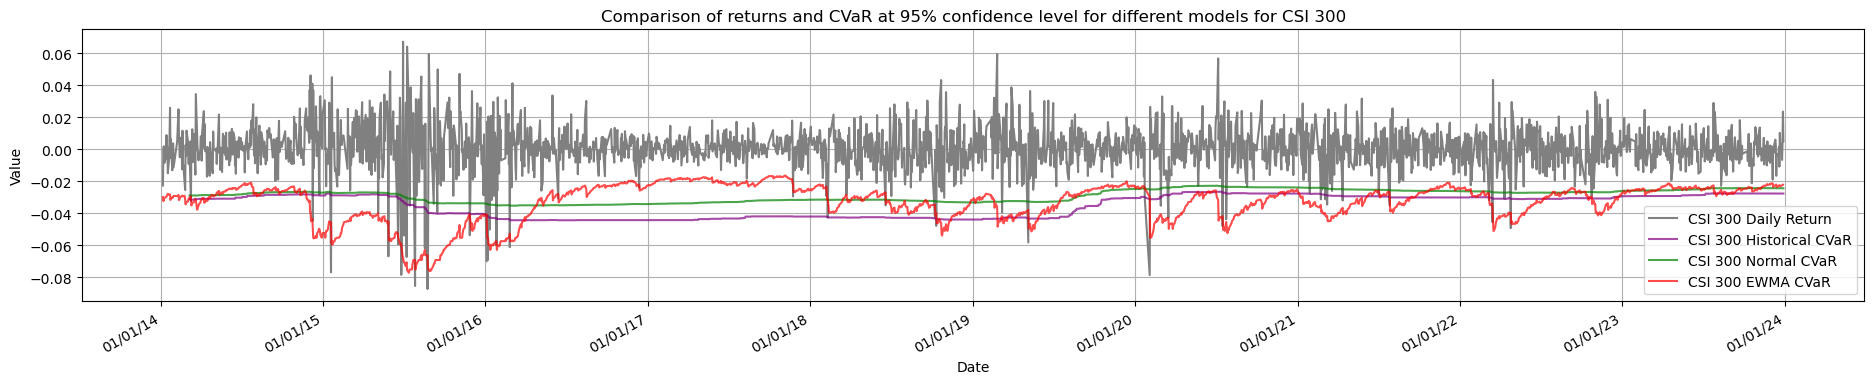

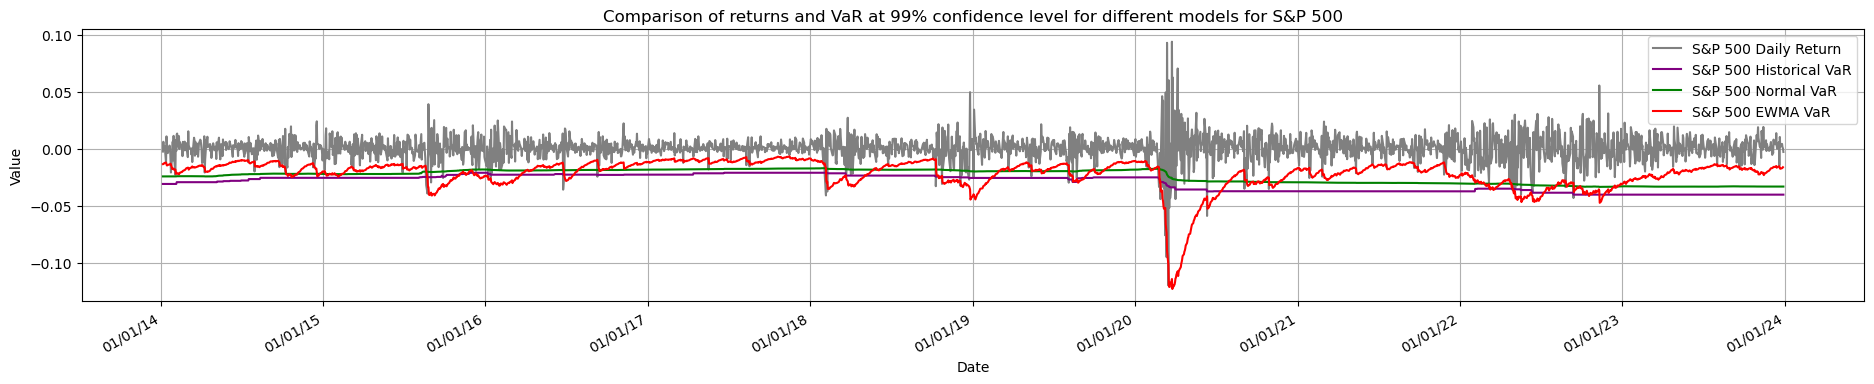

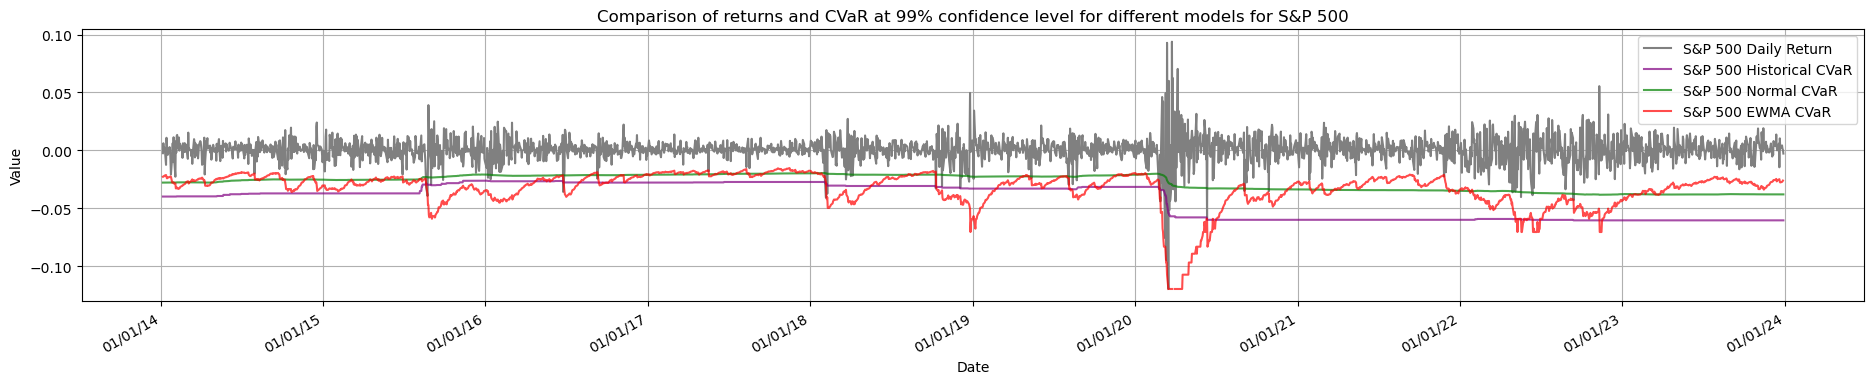

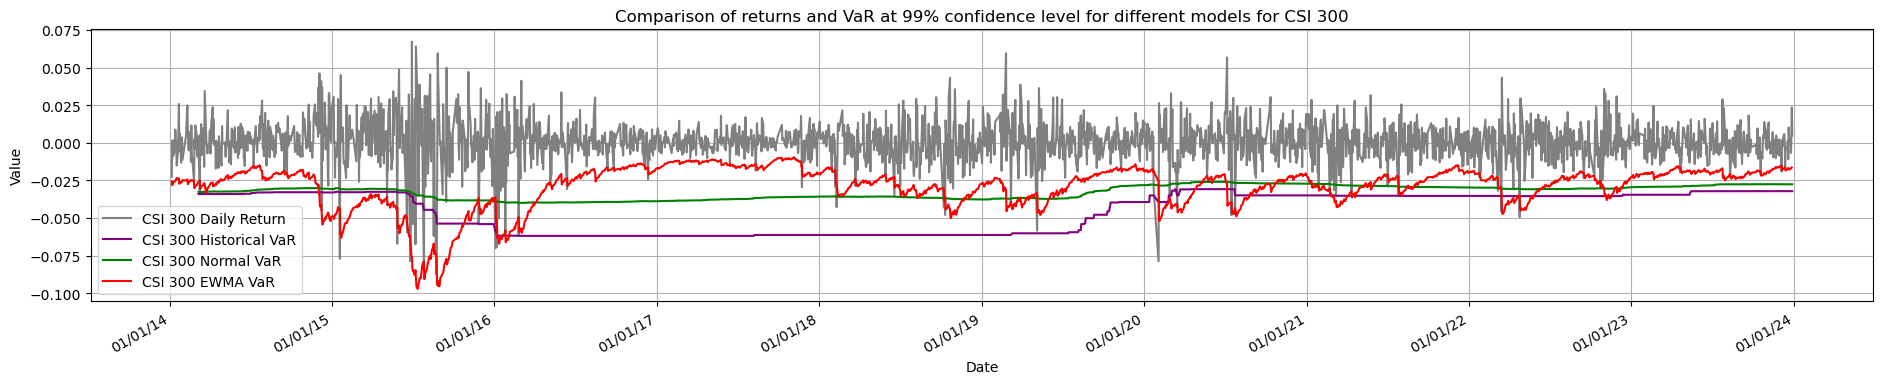

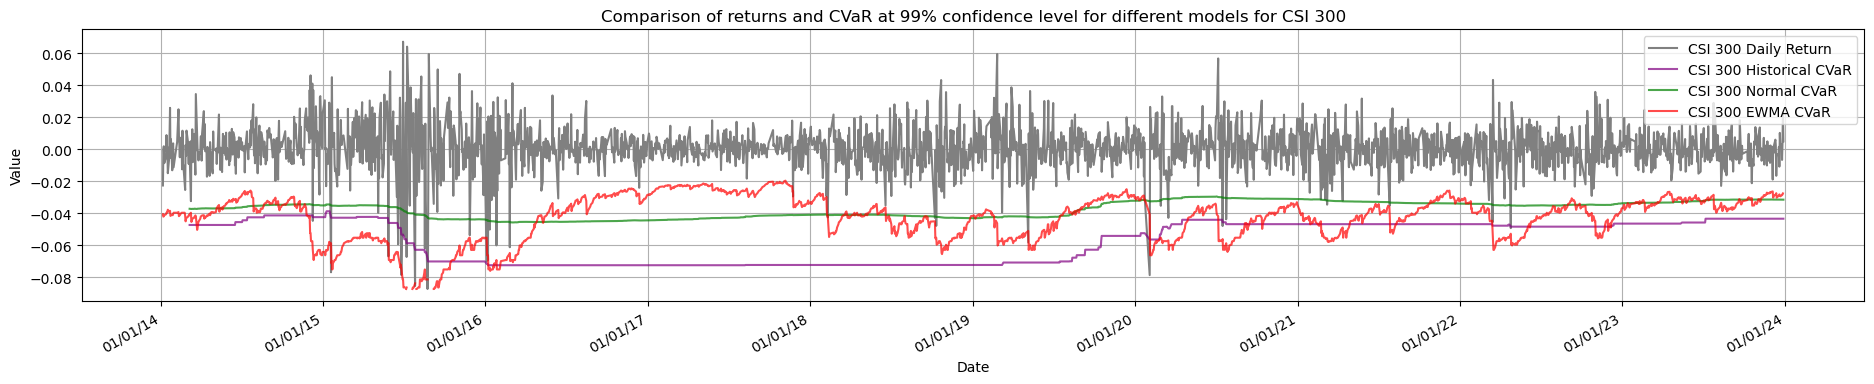

In [18]:
def calculate_var_cvar_windowed(returns, window_size, confidence_level):
    rolling_mean = returns.rolling(window_size).mean()
    rolling_std = returns.rolling(window_size).std()
    
    # Historical VaR and CVaR
    hist_var = returns.rolling(window_size).quantile(confidence_level)
    hist_cvar = returns.rolling(window_size).apply(
    lambda x: np.mean(x[x <= np.percentile(x, (confidence_level) * 100)]), raw=True
    )


    # Normal VaR and CVaR (assuming returns are normally distributed)
    norm_var = norm.ppf(confidence_level, rolling_mean, rolling_std)
    norm_cvar = rolling_mean + (norm.pdf(norm.ppf(confidence_level)) / - confidence_level) * rolling_std

    # EWMA VaR and CVaR
    lambda_factor = 0.94
    z_score = norm.ppf(1-confidence_level)
    sigma2 = pd.Series(index=returns.index, dtype='float64')
    sigma2.iloc[1] = returns.iloc[1] ** 2

    # Calculate the exponentially weighted sigma squared
    for i in range(2, len(returns)-1):
        sigma2.iloc[i] = (1 - lambda_factor) * returns.iloc[i - 1] ** 2 + lambda_factor * sigma2.iloc[i - 1]

    # Square root of sigma2 to get sigma
    sigma = np.sqrt(sigma2)

    # Calculate VaR
    ewma_var = pd.Series(index=returns.index, dtype='float64')
    ewma_cvar = pd.Series(index=returns.index, dtype='float64')
    # Calculate VaR and CVaR for each time point
    for k in range(len(returns)):
        ewma_var.iloc[k] = -z_score * sigma.iloc[k]
        
        # For CVaR, compute the mean of returns that are below the VaR threshold
        ewma_cvar.iloc[k] = returns[returns <= ewma_var.iloc[k]].mean()

    #ewma_var = -z_score * sigma
    # Create a series with the same index as returns for alignment
    #ewma_var_aligned = pd.Series(ewma_var, index=returns.index)

    
    
    return hist_var, hist_cvar, norm_var, norm_cvar, ewma_var, ewma_cvar


# Define the window size (4 years) and confidence level
window_size = 4 * 252  # 4 years window
#confidence_level = 0.05  # 95% confidence level

# Calculate daily returns if not already done
# sp500_data_cleaned['Daily_Return'] = sp500_data_cleaned['Close'].pct_change().dropna() * 100

# Calculate rolling VaR and CVaR for S&P 500 at 95% confidence level
sp500_data_cleaned['Rolling_Hist_VaR_95'], sp500_data_cleaned['Rolling_Hist_CVaR_95'], \
sp500_data_cleaned['Rolling_Norm_VaR_95'], sp500_data_cleaned['Rolling_Norm_CVaR_95'], \
sp500_data_cleaned['Rolling_EWMA_VaR_95'], sp500_data_cleaned['Rolling_EWMA_CVaR_95'] = calculate_var_cvar_windowed(
    sp500_data_cleaned['Daily_Return'], window_size, confidence_level=0.05
)
# Calculate rolling VaR and CVaR for S&P 500 at 99% confidence level
sp500_data_cleaned['Rolling_Hist_VaR_99'], sp500_data_cleaned['Rolling_Hist_CVaR_99'], \
sp500_data_cleaned['Rolling_Norm_VaR_99'], sp500_data_cleaned['Rolling_Norm_CVaR_99'], \
sp500_data_cleaned['Rolling_EWMA_VaR_99'], sp500_data_cleaned['Rolling_EWMA_CVaR_99'] = calculate_var_cvar_windowed(
    sp500_data_cleaned['Daily_Return'], window_size, confidence_level=0.01
)

# Calculate rolling VaR and CVaR for CSI 300 at 95% confidence level
csi300_data_cleaned['Rolling_Hist_VaR_95'], csi300_data_cleaned['Rolling_Hist_CVaR_95'], \
csi300_data_cleaned['Rolling_Norm_VaR_95'], csi300_data_cleaned['Rolling_Norm_CVaR_95'], \
csi300_data_cleaned['Rolling_EWMA_VaR_95'], csi300_data_cleaned['Rolling_EWMA_CVaR_95'] = calculate_var_cvar_windowed(
    csi300_data_cleaned['Daily_Return'], window_size, confidence_level=0.05
)

# Calculate rolling VaR and CVaR for CSI 300 at 99% confidence level
csi300_data_cleaned['Rolling_Hist_VaR_99'], csi300_data_cleaned['Rolling_Hist_CVaR_99'], \
csi300_data_cleaned['Rolling_Norm_VaR_99'], csi300_data_cleaned['Rolling_Norm_CVaR_99'], \
csi300_data_cleaned['Rolling_EWMA_VaR_99'], csi300_data_cleaned['Rolling_EWMA_CVaR_99'] = calculate_var_cvar_windowed(
    csi300_data_cleaned['Daily_Return'], window_size, confidence_level=0.01
)


def plot_var_cvar_95(results, prefix, confi_interval):

    # Convert 'Date' to datetime
    results['Date'] = pd.to_datetime(results['Date'], format='%m/%d/%y')
    
    # Sort the DataFrame just in case
    results.sort_values('Date', inplace=True)

    # Calculate the cutoff date, which is four years from the start
    cutoff_date = results['Date'].iloc[0] + pd.DateOffset(years=4)

    # Filter out the first four years
    results = results[results['Date'] > cutoff_date]

    plt.figure(figsize=(23, 4))   
    plt.plot(results['Date'], results['Daily_Return'], label=f'{prefix} Daily Return', linestyle='-', color='grey')
    plt.plot(results['Date'], results['Rolling_Hist_VaR_95'], label=f'{prefix} Historical VaR', linestyle='-', color='purple')
    plt.plot(results['Date'], results['Rolling_Norm_VaR_95'], label=f'{prefix} Normal VaR', linestyle='-', color='green') 
    plt.plot(results['Date'], results['Rolling_EWMA_VaR_95'], label=f'{prefix} EWMA VaR', linestyle='-', color='red')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Comparison of returns and VaR at {confi_interval} confidence level for different models for {prefix}')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.draw()
    plt.savefig(f'{prefix} var at {confi_interval}.png')
    plt.show()
    

    # Plot for CVaR
    plt.figure(figsize=(23, 4))
    plt.plot(results['Date'], results['Daily_Return'], label=f'{prefix} Daily Return', linestyle='-', color='grey')
    plt.plot(results['Date'], results['Rolling_Hist_CVaR_95'], label=f'{prefix} Historical CVaR', linestyle='-', color='purple', alpha=0.7)
    plt.plot(results['Date'], results['Rolling_Norm_CVaR_95'], label=f'{prefix} Normal CVaR', linestyle='-', color='green', alpha=0.7)
    plt.plot(results['Date'], results['Rolling_EWMA_CVaR_95'], label=f'{prefix} EWMA CVaR', linestyle='-', color='red', alpha=0.7)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Comparison of returns and CVaR at {confi_interval} confidence level for different models for {prefix}')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.draw()
    plt.savefig(f'{prefix} cvar at {confi_interval}.png')
    plt.show()
    

plot_var_cvar_95(sp500_data_cleaned, prefix='S&P 500', confi_interval = '95%' )
plot_var_cvar_95(csi300_data_cleaned, prefix='CSI 300', confi_interval = '95%' )


def plot_var_cvar_99(results, prefix, confi_interval):

    # Convert 'Date' to datetime
    results['Date'] = pd.to_datetime(results['Date'], format='%m/%d/%y')
    
    # Sort the DataFrame just in case
    results.sort_values('Date', inplace=True)

    # Calculate the cutoff date, which is four years from the start
    cutoff_date = results['Date'].iloc[0] + pd.DateOffset(years=4)

    # Filter out the first four years
    results = results[results['Date'] > cutoff_date]

    plt.figure(figsize=(23, 4))   
    plt.plot(results['Date'], results['Daily_Return'], label=f'{prefix} Daily Return', linestyle='-', color='grey')
    plt.plot(results['Date'], results['Rolling_Hist_VaR_99'], label=f'{prefix} Historical VaR', linestyle='-', color='purple')
    plt.plot(results['Date'], results['Rolling_Norm_VaR_99'], label=f'{prefix} Normal VaR', linestyle='-', color='green') 
    plt.plot(results['Date'], results['Rolling_EWMA_VaR_99'], label=f'{prefix} EWMA VaR', linestyle='-', color='red')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Comparison of returns and VaR at {confi_interval} confidence level for different models for {prefix}')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.draw()
    plt.savefig(f'{prefix} var at {confi_interval}.png')
    plt.show()
    

    # Plot for CVaR
    plt.figure(figsize=(23, 4))
    plt.plot(results['Date'], results['Daily_Return'], label=f'{prefix} Daily Return', linestyle='-', color='grey')
    plt.plot(results['Date'], results['Rolling_Hist_CVaR_99'], label=f'{prefix} Historical CVaR', linestyle='-', color='purple', alpha=0.7)
    plt.plot(results['Date'], results['Rolling_Norm_CVaR_99'], label=f'{prefix} Normal CVaR', linestyle='-', color='green', alpha=0.7)
    plt.plot(results['Date'], results['Rolling_EWMA_CVaR_99'], label=f'{prefix} EWMA CVaR', linestyle='-', color='red', alpha=0.7)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Comparison of returns and CVaR at {confi_interval} confidence level for different models for {prefix}')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.draw()
    plt.savefig(f'{prefix} cvar at {confi_interval}.png')
    plt.show()
    

plot_var_cvar_99(sp500_data_cleaned, prefix='S&P 500', confi_interval = '99%' )
plot_var_cvar_99(csi300_data_cleaned, prefix='CSI 300', confi_interval = '99%' )

In [4]:
def count_var_cvar_exceedances(daily_returns, var_list, cvar_list):
    var_exceedances = sum(return_ < var for return_, var in zip(daily_returns, var_list))
    cvar_exceedances = sum(return_ < cvar for return_, cvar in zip(daily_returns, cvar_list))
    return var_exceedances, cvar_exceedances

exceedances_sp500 = {}
exceedances_csi300 = {}

# For each type of VaR and CVaR, calculate the number of exceedances
for method in ['historical', 'parametric', 'modified']:
    exceedances_sp500[method + '_var'], exceedances_sp500[method + '_cvar'] = \
        count_var_cvar_exceedances(sp500_data_cleaned['Daily Return'], results_sp500[method + '_var'], results_sp500[method + '_cvar'])

    exceedances_csi300[method + '_var'], exceedances_csi300[method + '_cvar'] = \
        count_var_cvar_exceedances(csi300_data_cleaned['Daily Return'], results_csi300[method + '_var'], results_csi300[method + '_cvar'])
# Calculate total observations for both datasets
total_observations_sp500 = len(sp500_data_cleaned) - window_size
total_observations_csi300 = len(csi300_data_cleaned) - window_size
# Define the traffic light categorization function
def traffic_light(surpass_count, total_observations):
    ratio = surpass_count / total_observations
    if ratio <= 0.05:
        return 'Green'  # Within tolerance
    elif ratio <= 0.10:
        return 'Yellow'  # Requires attention
    else:
        return 'Red'  # Outside of expected tolerance, significant concern

traffic_light_results_99 = {
    'Type': ['Historical VaR', 'Parametric VaR', 'Modified VaR', 'Historical CVaR', 'Parametric CVaR', 'Modified CVaR'],
    'S&P 500': [
        traffic_light(exceedances_sp500['Rolling_Hist_VaR_99'], total_observations_sp500),
        traffic_light(exceedances_sp500['Rolling_Norm_VaR_99'], total_observations_sp500),
        traffic_light(exceedances_sp500['Rolling_EWMA_VaR_99'], total_observations_sp500),
        traffic_light(exceedances_sp500['Rolling_Hist_CVaR_99'], total_observations_sp500),
        traffic_light(exceedances_sp500['Rolling_Norm_CVaR_99'], total_observations_sp500),
        traffic_light(exceedances_sp500['Rolling_EWMA_CVaR_99'], total_observations_sp500)
    ],
    'CSI 300': [
        traffic_light(exceedances_csi300['Rolling_Hist_VaR_99'], total_observations_csi300),
        traffic_light(exceedances_csi300['Rolling_Norm_VaR_99'], total_observations_csi300),
        traffic_light(exceedances_csi300['Rolling_EWMA_VaR_99'], total_observations_csi300),
        traffic_light(exceedances_csi300['Rolling_Hist_CVaR_99'], total_observations_csi300),
        traffic_light(exceedances_csi300['Rolling_Norm_CVaR_99'], total_observations_csi300),
        traffic_light(exceedances_csi300['Rolling_EWMA_CVaR_99'], total_observations_csi300)
    ]
}

# Convert the results to a DataFrame
traffic_light_df = pd.DataFrame(traffic_light_results)
traffic_light_df

KeyError: 'Daily Return'